# <font face="Verdana" size=6 color='#6495ED'> IAD-004 APRENDIZAGEM DE M√ÅQUINA 1
<font face="Verdana" size=3 color='#40E0D0'> Professores Larissa Driemeier e Thiago Martins

<center><img src='https://drive.google.com/uc?export=view&id=1J3dF7v9apzpj27oOsrT8aEagtNIYwq7J' width="600"></center>

Este notebook introdut√≥rio √© sobre __M√°quinas de Vetores de suporte__, baseado na aula [IAD-004](https://alunoweb.net/moodle/pluginfile.php/143143/mod_resource/content/1/ML1_C05_SVM_Y2024.pdf), ano 2024.

O Notebook apresentado √© uma compila√ß√£o de ideias apresentadas nas seguintes fontes:

1. Livro [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) de Jake VanderPlas, cuja programa√ß√£o em Python est√° dispon√≠vel no [GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).
2. Texto [SVM Example](http://axon.cs.byu.edu/Dan/678/miscellaneous/SVM.example.pdf), elaborado por Dan Ventura.
3. Notas de aula [CS229 Lecture Notes](http://cs229.stanford.edu/notes/cs229-notes3.pdf), elaboradas por Angrew Ng.
4. Exemplo [k-fold](https://machinelearningmastery.com/k-fold-cross-validation/), por Jason Brownlee.
5. Artigo cl√°ssico [Data classification using Support vector Machine (SVM), a simplified approach ](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.683.210&rep=rep1&type=pdf), de S. Amarappa e S. V. Sathyanarayana.

## O que √© SVM?

M√°quina de Vetores de Suporte, ou SVMs (do ingl√™s, Support Vector Machine) √© um m√©todo de aprendizado relativamente novo usado para classifica√ß√£o bin√°ria. A id√©ia b√°sica √© encontrar um hiperplano que separe perfeitamente os dados $d$-dimensionais em suas duas classes. No entanto, como os dados de exemplo geralmente n√£o s√£o separ√°veis linearmente, os SVMs introduzem a no√ß√£o de um *espa√ßo de recursos induzido pelo kernel* que lan√ßa os dados em um espa√ßo dimensional mais alto, geralmente desconhecido, onde os dados s√£o separ√°veis.

O SVM foi proposto por Vladimir Vapnik, em sua tese de doutorado na d√©cada de 60. As M√°quinas de Vetores de Suporte foram introduzidas pela primeira vez para resolver os problemas de classifica√ß√£o de padr√µes de escrita em 1992, quando Vapnik migrou para os EUA para trabalhar na Bell Labs. Em 1992, Vapnik e colegas tiveram a ideia de aplicar o que √© chamado de *Kernel Trick*, que permite usar o SVM para classificar dados linearmente n√£o separ√°veis.

Os SVMs s√£o poderosos, pois desfrutam de uma base te√≥rica s√≥lida e de sucesso em aplica√ß√µes do mundo real. Possui uma estrutura simples e requer menos n√∫mero de recursos.

N√£o iremos usar as ferramentas do Python, que tornam extremamente simples a aplica√ß√£o do modelo. Para ilustrar as id√©ias b√°sicas, iremos resolver passo a passo um problema te√≥rico. Come√ßaremos com um SVM linear (ou seja, um modelo que assume que os dados s√£o linearmente separ√°veis) e depois expandiremos o exemplo para o caso n√£o linear para demonstrar o papel da fun√ß√£o de mapeamento. Finalmente, explicaremos a id√©ia de um kernel e como ele permite que os SVMs utilizem espa√ßos de *features* de alta dimens√£o.

Importando os pacotes necess√°rios

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVC # "Support vector classifier"

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d

# use seaborn plotting defaults
import seaborn as sns; sns.set()

In [2]:
import cvxopt.solvers

## Margem hard linear
Suponha o conjunto de dados positivos e negativos, respectivamente:
$$
x_+ = \left\{ \left(
\begin{array}{c}
3\\ 1
\end{array} \right), \left(
\begin{array}{c}
3\\ -1
\end{array} \right), \left(
\begin{array}{c}
6\\ 1
\end{array} \right),\left(
\begin{array}{c}
6\\ -1
\end{array} \right)
\right\}
$$
e
$$
x_- = \left\{ \left(
\begin{array}{c}
1\\ 0
\end{array} \right), \left(
\begin{array}{c}
0\\ 1
\end{array} \right), \left(
\begin{array}{c}
0\\ -1
\end{array} \right),\left(
\begin{array}{c}
-1\\ 0
\end{array} \right)
\right\}
$$

Queremos usar a t√©cnica mais simples de SVM para discriminar com precis√£o as duas classes. Como os dados s√£o linearmente separ√°veis, podemos usar um SVM linear.

Primeiros passos:
* Plotar os dados;
* Encontrar os vetores de suporte


In [3]:
norm = mpl.colors.Normalize(-1,1)
colors = [[norm(-1.0), "teal"],
          [norm(-0.6), "darkseagreen"],
          [norm( 0.6), "steelblue"],
          [norm( 1.0), "navy"]]

mycmap = mpl.colors.LinearSegmentedColormap.from_list("", colors)

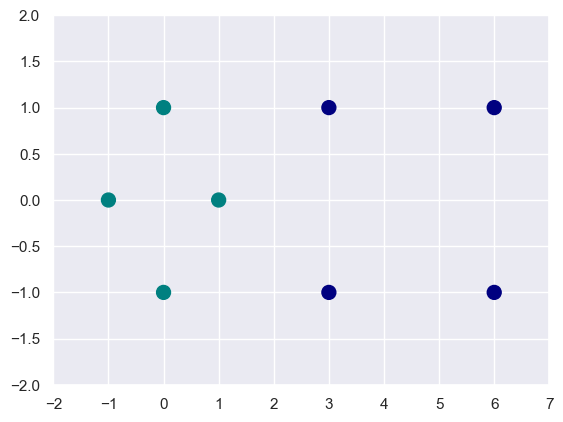

In [4]:
# dados positivos
xp = np.array([3, 3, 6., 6.])
yp = np.array([1., -1., 1., -1.])

#dados negativos
xn = np.array([1., 0., 0., -1.])
yn = np.array([0., 1., -1., 0.])

#
a= np.array([xp ,yp])
b= np.array([xn,yn])
X = np.concatenate((a, b), axis=1)
y = [1, 1, 1, 1, -1, -1, -1, -1]
plt.scatter(X[0,:], X[1,:], c=y, s=100, cmap=mycmap)
plt.xlim(-2, 7)
plt.ylim(-2, 2)
plt.show()

Um classificador discriminativo linear tentaria desenhar uma linha reta que separasse os dois conjuntos de dados e, assim, criar um modelo para classifica√ß√£o. Para dados bidimensionais como os nossos, essa √© uma tarefa que podemos realizar manualmente. Mas imediatamente vemos um problema: h√° mais de uma linha divis√≥ria poss√≠vel que pode discriminar perfeitamente entre as duas classes! Veja o gr√°fico plotado a seguir.


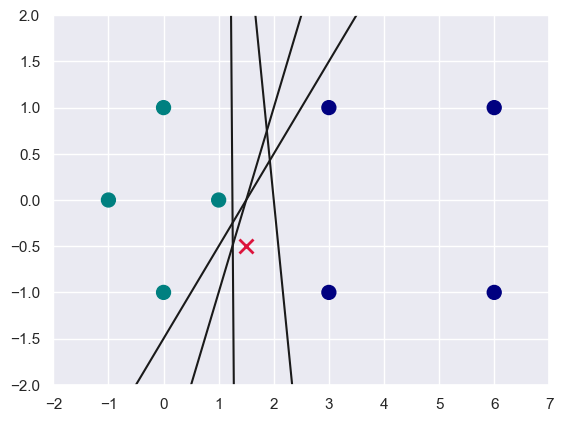

In [5]:
xfit = np.linspace(-1, 6)
plt.scatter(X[0,:], X[1,:], c=y, s=100, cmap=mycmap)
plt.plot([1.5], [-0.5], 'x', color='crimson', markeredgewidth=2, markersize=10)

for m, b in [(2, -3), (1, -1.5), (-6, 12), (-80, 100)]:
    plt.plot(xfit, m * xfit + b, '-k')
plt.xlim(-2, 7)
plt.ylim(-2, 2);


Os hiperplanos separadores apresentados s√£o muito diferentes, por√©m, discriminam perfeitamente essas amostras. Dependendo da sua escolha, um novo ponto de dados (por exemplo, o marcado pelo "X" vermelho no gr√°fico) receber√° um r√≥tulo diferente! Evidentemente, nossa simples intui√ß√£o de "tra√ßar uma linha entre as classes" n√£o √© suficiente, e precisamos pensar um pouco mais.

E a ilustra√ß√£o de um novo dado em vermelho mostra que a resposta de nosso classificador depender√° do hiperplano que escolhermos.

### M√°quinas de vetores de suporte: maximizando a *margem*

As m√°quinas de vetores de suporte oferecem uma maneira de melhorar isso.
A intui√ß√£o √© a seguinte: em vez de simplesmente desenhar uma linha de largura zero entre as classes, podemos desenhar em torno de cada linha uma *margem* de alguma largura, at√© o ponto mais pr√≥ximo...

<center><img src='https://drive.google.com/uc?export=view&id=1pB4IqFcJxynCgof82ExhP7GkkpIVXYAR' width="500"></center>

Em SVM, a linha que maximiza essa margem √© a que escolheremos como o modelo ideal.

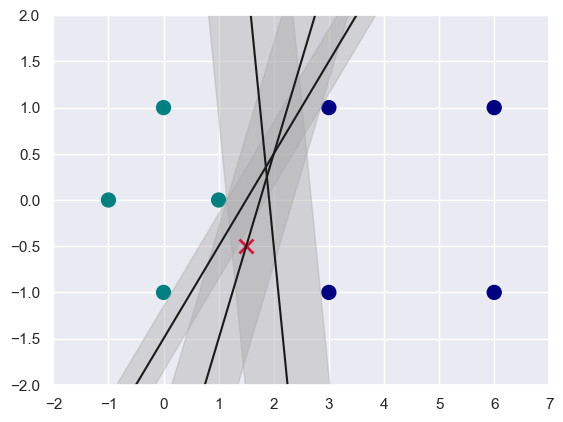

In [6]:
xfit = np.linspace(-1, 6)
plt.scatter(X[0,:], X[1,:], c=y, s=100, cmap=mycmap)
plt.plot([1.5], [-0.5], 'x', color='crimson', markeredgewidth=2, markersize=10)

for m, b, d in [(2, -3.5, 1.2), (1, -1.5, 0.35), (-6, 11.5, 4.6)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)
plt.xlim(-2, 7)
plt.ylim(-2, 2);

A seguir, usamos uma biblioteca Python somente para termos um *gabarito* para nosso exerc√≠cio.

In [7]:
model = SVC(kernel='linear', C=1E10)
model.fit(X.T, y)

SVC(C=10000000000.0, kernel='linear')

A fun√ß√£o `plot_SVC` definida abaixo e plota o resultado obtido pela biblioteca Pyhton sobre o gr√°fico com todos os vetores.




In [8]:
def plot_SVC(model, ax=None, plot_support=True):
    """Plotagem da margem m√°xima"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # grid para avaliar o modelo
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T

    # Aplica o modelo treinado no grid
    P = model.decision_function(xy).reshape(X.shape)

    print('Coeficientes do modelo w1, w2 ='+ str(model.coef_))
    print('b = '+str(model.intercept_))
    # Plota as linhas de limite de classifica√ß√£o e margens de decis√£o (n√≠veis -1,0,1)
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # Plota os vetores de suporte
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   marker='o', s=500, edgecolor='black', facecolors='crimson',
                   linewidth=1, alpha = 0.95);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Coeficientes do modelo w1, w2 =[[ 1.00048166e+00 -1.66533454e-16]]
b = [-2.00112388]


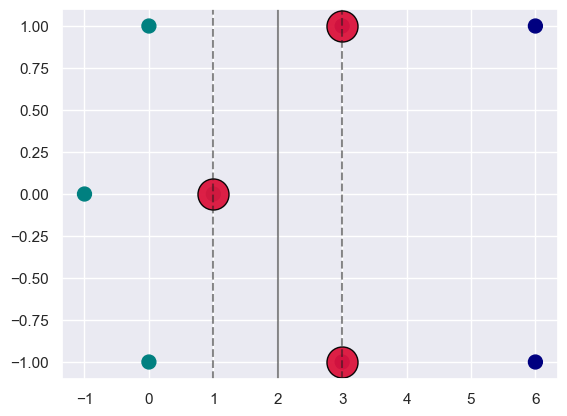

In [9]:
plt.scatter(X[0,:], X[1,:], c=y, s=100, cmap=mycmap)
plot_SVC(model)

##SVM e o problema de Lagrange

Quando falamos em  *maximizar* a margem, estamos falando de um problema de otimiza√ß√£o, com restri√ß√µes. Particularmente, nosso caso √© um exemplo de programa√ß√£o quadr√°tica e, devemos, portanto, minimizar uma fun√ß√£o quadr√°tica sujeita a restri√ß√µes lineares,

\begin{aligned}&{\underset {\boldsymbol{\omega},b}{\operatorname {minimizar} }}&&L(\boldsymbol{\omega},b)=\frac{1}{2}||\boldsymbol{\omega}||^2\\&\operatorname {sujeito\;a} &&y^{(i)}\left(\boldsymbol{\omega}^Tx^{(i)}+b\right)\ge 1\end{aligned}

Essa otimiza√ß√£o √© chamada de problema primal e √© garantido que tenha um m√≠nimo global. Podemos resolver  introduzindo multiplicadores de Lagrange ($\alpha_i$) e convertendo-a para o problema dual:
\begin{equation}
{\underset {\boldsymbol{\alpha}}{\operatorname {max} }}
\text{  } {\underset {\boldsymbol{\omega},b}{\operatorname {min} }}
\text{  }L(\boldsymbol{\omega},b,\boldsymbol{\alpha})
\end{equation}
onde,
\begin{equation}
L(\boldsymbol{\omega},b,\boldsymbol{\alpha})=\frac{1}{2}||\boldsymbol{\omega}||^2-\sum_{i=1}^m{\alpha_i \left[y^{(i)}\left(\boldsymbol{\omega}^T\boldsymbol{x}^{(i)}+b\right)- 1\right]}
\end{equation}

Essa √© a fun√ß√£o Lagrangiana do SVM, que √© diferenci√°vel em rela√ß√£o a $\boldsymbol{\omega}$ e $b$,

\begin{cases} \frac{\partial{L}}{\partial \boldsymbol{\omega}} = 0 \Longrightarrow \boldsymbol{\omega}=\sum_{i=1}^m{\alpha_iy^{(i)}\boldsymbol{x}^{(i)}} \\ \frac{\partial{L}}{\partial b} = 0 \Longrightarrow \boldsymbol{\omega}=\sum_{i=1}^m{\alpha_iy^{(i)}=0}\end{cases}

Ao substituir os resultados acima na fun√ß√£o Lagrangiana, obteremos o problema dual do SVM:

\begin{aligned}&{\underset {\boldsymbol{\alpha}}{\operatorname {maximizar} }}\quad L(\boldsymbol{\alpha})=\sum_{i=1}^m \alpha_i - \frac{1}{2}\sum_{i=1}^m{\sum_{j=1}^m {\alpha_i \alpha_j y^{(i)}y^{(j)}\boldsymbol{x}^{(i)T}\boldsymbol{x}^{(j)}}}\\&\operatorname {sujeito\;a} \quad\alpha_i \ge 0,\qquad i=1,\cdots,m\end{aligned}
com a seguinte restri√ß√£o em $\alpha$,

\begin{equation}
\sum_{i=1}^m \alpha_i y^{(i)} = 0
\end{equation}

O problema acima pode ser escrito na forma quadr√°tica convexa de um problema cl√°ssico de otimiza√ß√£o
\begin{array}{cl}{\underset{x}{\operatorname{minimize}}} & {\frac{1}{2} \boldsymbol{\alpha}^{T} \mathbf{P} \boldsymbol{\alpha}+\mathbf{q}^{T} \boldsymbol{\alpha}} \\ {\text { sujeito a }} & {\mathbf{G} \boldsymbol{\alpha} \leq \mathbf{h}} \\ {} & {\mathbf{A} \boldsymbol{\alpha}=\mathbf{b}}\end{array}

Veja que podemos reescrever cpode ser reescrito como:
\begin{array}{cl}{\underset{\alpha}{\operatorname{minimize}}} & {\frac{1}{2} \boldsymbol{\alpha}^{T}\left(\mathbf{y y}^{T} \mathbf{K}\right) \boldsymbol{\alpha}-\boldsymbol{1}^T \boldsymbol{\alpha}} \\ {\text { sujeito a }} & {-\boldsymbol{\alpha} \leq \mathbf{0}} \\ {} & {\mathbf{y} \cdot \boldsymbol{\alpha}=0}\end{array}
onde:
$$
\boldsymbol{\alpha}=\left(\alpha_{1}, \ldots, \alpha_{m}\right)^{T},\mathbf{y}=\left(y_{1}, \cdots, y_{m}\right)^{T}  \text { e }  \boldsymbol{1}=\left(1, \ldots,1 \right)^{T}
$$
e
$$
K\left(\mathbf{x}_{1}, \ldots, \mathbf{x}_{m}\right)=\left(\begin{array}{cccc}{\mathbf{x}_{1} \cdot \mathbf{x}_{1}} & {\mathbf{x}_{1} \cdot \mathbf{x}_{2}} & {\dots} & {\mathbf{x}_{1} \cdot \mathbf{x}_{m}} \\ {\mathbf{x}_{2} \cdot \mathbf{x}_{1}} & {\mathbf{x}_{2} \cdot \mathbf{x}_{2}} & {\ldots} & {\mathbf{x}_{2} \cdot \mathbf{x}_{m}} \\ {\vdots} & {\vdots} & {\ddots} & {\vdots} \\ {\mathbf{x}_{m} \cdot \mathbf{x}_{1}} & {\mathbf{x}_{m} \cdot \mathbf{x}_{2}} & {\dots} & {\mathbf{x}_{m} \cdot \mathbf{x}_{m}}\end{array}\right)
$$

O problema de Lagrange retorna os valores de $\alpha_i$ diferentes de zero para os vetores de suporte, que s√£o os vetores que atingem a menor dist√¢ncia da margem. S√£o pontos de dados de treinamento que est√£o mais pr√≥ximos do hiperplano e influenciam a posi√ß√£o e a orienta√ß√£o do hiperplano. Usando esses vetores de suporte, maximizamos a margem do classificador.

Os vetores de suporte s√£o os exemplos mais dif√≠ceis de classificar. S√£o os elementos cr√≠ticos do conjunto de treinamento.

Somente um subconjunto muito pequeno de amostras de treinamento (vetores de suporte) pode especificar completamente a fun√ß√£o de decis√£o. Os pontos interiores n√£o contribuem em nada para solu√ß√£o!


O modelo de classifica√ß√£o √© obtido comm $\boldsymbol{\omega}$ e $b$. O vetor $\boldsymbol{\omega}$ √© simples de obter, porque a f√≥rmula para$\boldsymbol{\omega}$ √© uma das restri√ß√µes que usamos para montar nosso problema quadr√°tico,
\begin{equation}
\boldsymbol{\omega}=\sum_{i=1}^{n_{sv}}{\alpha_iy^{(i)}\boldsymbol{x}^{(i)}}
\end{equation}
onde $n_{sv}$ √© o n√∫mero de vetores de suporte.

Para encontrar o valor de $b$ usamos a equa√ß√£o abaixo para qualquer vetor de suporte $\boldsymbol{x}^{(i)}$:
\begin{equation}
y^{(i)}\left(\boldsymbol{\omega}^T\boldsymbol{x}^{(i)}+b\right)=1
\end{equation}

A classifica√ß√£o de um novo vetor de caracter√≠sticas $\mathbf{x}$ √© dado por:
$$
h\left(\mathbf{x}^{(i)}\right)=\operatorname{sign}\left(\mathbf{w} \cdot \mathbf{x}^{(i)}+b\right)
$$

Uma chave para o sucesso desse classificador √© que, para o ajuste, apenas a posi√ß√£o dos vetores de suporte √© importante; quaisquer pontos mais afastados da margem, desde que estejam do lado correto da classifica√ß√£o,  n√£o modificam o ajuste! Tecnicamente, isso ocorre porque esses pontos n√£o contribuem para a fun√ß√£o de perda usada para ajustar o modelo, portanto, sua posi√ß√£o e n√∫mero n√£o importam, desde que n√£o ultrapassem a margem.


### Um par√™nteses sobre o multiplicador de Lagrange

Imagine que voc√™ deseja minimizar alguma fun√ß√£o de duas vari√°veis, digamos $f(x, y) = x^2 + y^2$. Claramente, isso tem um m√≠nimo em $(x, y) = (0,0)$.

Mas e se exigirmos que $x + y = 1$? Onde est√° o m√≠nimo que obedece a essa condi√ß√£o?

A maneira for√ßa bruta √© isolar $y = 1 - x$, ent√£o

$$
f(x, y) = f(x, y(x)) = x^2 + (1 - x)^2 = 2x^2 + 1 - 2x
$$

e, portanto, o m√≠nimo, diferenciando:

$$
f'(x) = 4x - 2 = 0
$$

√© em $x = \frac{1}{2}$, ou seja, em $(x, y) = \left(\frac{1}{2}, \frac{1}{2}\right)$.

Tamb√©m podemos escrever a condi√ß√£o como

$$
x + y - 1 = 0 = \lambda (x + y - 1)
$$

Multiplicamos por $\lambda$, o que √© permitido, pois igualamos a zero de qualquer maneira. Vamos adicionar zero, ou seja, esse tipo especial de zero, a $f(x, y)$:

$$
f(x, y) = x^2 + y^2 + \lambda (x + y - 1)
$$

Agora vamos tentar minimizar novamente, mas agora considere $x$ e $y$ independentes:

$$
\frac{\partial f}{\partial x} = 2x + \lambda = 0
$$

$$
\frac{\partial f}{\partial y} = 2y + \lambda = 0
$$

Eliminando $\lambda$ obtemos $x = y$.

Sabendo que $x = y$ nos d√° imediatamente $(x, y) = \left(\frac{1}{2}, \frac{1}{2}\right)$ a partir de $x + y = 1$. Ent√£o, adicionar esse $\lambda$ nos permitiu pular a etapa de substitui√ß√£o. Podemos tamb√©m resolver para $\lambda$ se quisermos: $\lambda = -1$.

$\lambda$ √© conhecido como um multiplicador de Lagrange. √â simplesmente um truque inteligente. Tamb√©m n√£o √© muito dif√≠cil provar que funciona, mas vou pular isso aqui. Em conclus√£o: um multiplicador de Lagrange √© uma vari√°vel que introduzimos para encontrar um extremo.


C:\Users\mathe\AppData\Local\Temp\ipykernel_14544\1945759778.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(0, 0,  s=20, marker='o', cmap='viridis')


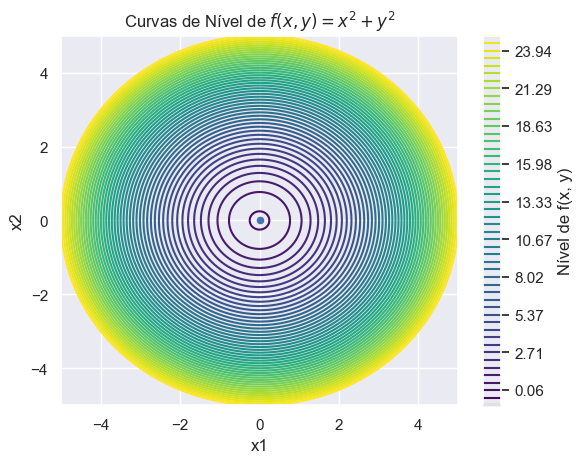

In [10]:
# Definindo a fun√ß√£o f(x, y) = x^2 + y^2
def f(x, y):
    return x**2 + y**2

# Criando uma grade de valores de x e y
x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# Desenhando as curvas de n√≠vel
plt.scatter(0, 0,  s=20, marker='o', cmap='viridis')
plt.contour(X, Y, Z, levels=np.linspace(-1, 25, 50), cmap='viridis')
plt.colorbar(label='N√≠vel de f(x, y)')

# Adicionando t√≠tulos e r√≥tulos
plt.title('Curvas de N√≠vel de $f(x, y) = x^2 + y^2$')
plt.xlabel('x1')
plt.ylabel('x2')

# Mostrando o gr√°fico
plt.grid(True)
plt.show()

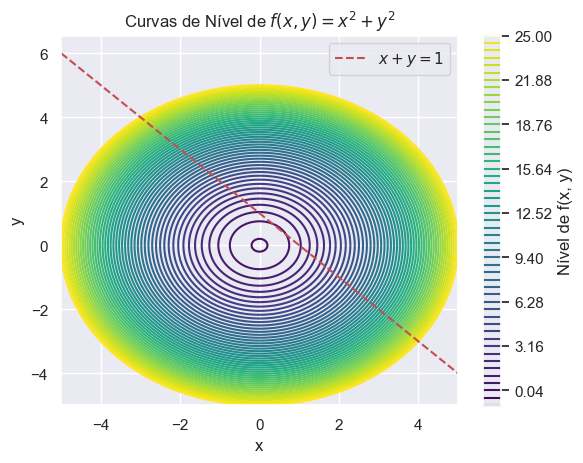

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Definindo a fun√ß√£o f(x, y) = x^2 + y^2
def f(x, y):
    return x**2 + y**2

# Criando uma grade de valores de x e y
x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# Desenhando as curvas de n√≠vel
#plt.scatter(1/2, 1/2,  s=20, marker='o', cmap='viridis')
plt.contour(X, Y, Z, levels=np.linspace(-1, 25, 51), cmap='viridis')
plt.colorbar(label='N√≠vel de f(x, y)')

# Adicionando a linha x + y = 1
x_line = np.linspace(-5, 5, 400)
y_line = 1 - x_line
plt.plot(x_line, y_line, 'r--', label='$x + y = 1$')

# Adicionando t√≠tulos e r√≥tulos
plt.title('Curvas de N√≠vel de $f(x, y) = x^2 + y^2$')
plt.xlabel('x')
plt.ylabel('y')

# Adicionando uma legenda
plt.legend()

# Mostrando o gr√°fico
plt.grid(True)
plt.show()


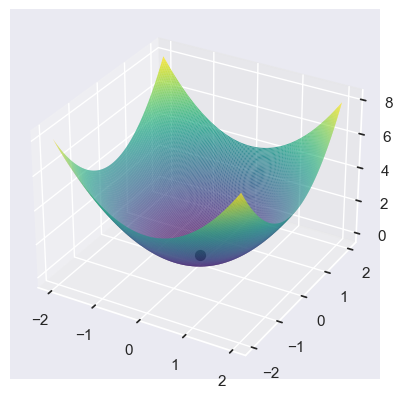

In [12]:
max_x = 2
min_x = -2
n_x = 300
max_y = 2
min_y = -2
n_y = 300
xx, yy = np.meshgrid(np.linspace(min_x, max_x, n_x), np.linspace(min_y, max_y, n_y))
f_xy = xx**2+yy**2
g_xy = xx +yy - 1

th = 0.05
ax = plt.figure().add_subplot(projection='3d')
cc = np.repeat(np.where(np.abs(g_xy)<th, 0.0,1.0)[:,:,np.newaxis],3,axis=2)
ax.plot_surface(xx, yy, f_xy,cmap = 'viridis',  rcount = 400, ccount=200, alpha = 0.9, lw=0.);
ax.scatter(0,0,0, color='black', s=50);

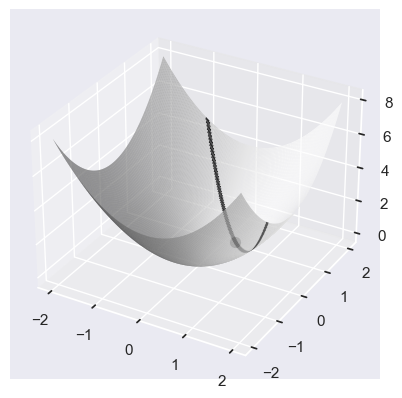

In [13]:
max_x = 2
min_x = -2
n_x = 300
max_y = 2
min_y = -2
n_y = 300
xx, yy = np.meshgrid(np.linspace(min_x, max_x, n_x), np.linspace(min_y, max_y, n_y))
f_xy = xx**2+yy**2
g_xy = xx +yy - 1

th = 0.05
ax = plt.figure().add_subplot(projection='3d')
cc = np.repeat(np.where(np.abs(g_xy)<th, 0.0,1.0)[:,:,np.newaxis],3,axis=2)
ax.plot_surface(xx, yy, f_xy,facecolors=cc,  rcount = 400, ccount=200, alpha = 0.9, lw=0.);
ax.scatter(1/2, 1/2, 1/2, color='black', s=50);

### Solu√ß√£o sem resolver o problema de otimiza√ß√£o

Teoricamente, tem-se a defini√ß√£o de,
$$
\omega^T x^{(j)}+b = \sum_{i=1}^{n_{sv}} \alpha_i y^{(i)} \langle x^{(i)},x^{(j)}\rangle + b = y^{(i)}
$$
onde $\langle x^{(i)},x^{(j)}\rangle$ √© o produto interno entre os vetores $x^{(i)}$ e $x^{(j)}$ e $n_{sv}$, conforme j√° mencionado, √© o n√∫mero de vetores de suporte.

Para nosso exemplo, teremos,
$$
\alpha_1 y^{(1)} x^{(1)}\cdot x^{(1)} + \alpha_2 y^{(2)} x^{(2)}\cdot x^{(1)} + \alpha_3 y^{(3)} x^{(3)}\cdot x^{(1)} +b = y^{(1)} \\
\alpha_1 y^{(1)} x^{(1)}\cdot x^{(2)} + \alpha_2 y^{(2)} x^{(2)}\cdot x^{(2)} + \alpha_3 y^{(3)} x^{(3)}\cdot x^{(2)} +b = y^{(2)} \\ \tag{1}
\alpha_1 y^{(1)} x^{(1)}\cdot x^{(3)} + \alpha_2 y^{(2)} x^{(2)}\cdot x^{(3)} + \alpha_3 y^{(3)} x^{(3)}\cdot x^{(3)} +b = y^{(3)}
$$

Por inspe√ß√£o, verifica-se que os vetores de suporte s√£o 3: $(1,0)$ para $y=-1$; $(3,1)$, para $y=+1$; e $(3,-1)$, para $y=+1$. Dessa forma, pode-se escrever os vetores de suporte $sv_i, i=1,...,3$ como,
$$
sv_1 = \left(
\begin{array}{c}
 1 \\0
\end{array} \right)
 \qquad
sv_2 = \left(
\begin{array}{c}
3 \\ 1
\end{array} \right)
 \qquad
sv_3 = \left(
\begin{array}{c}
3 \\ -1
\end{array} \right)
$$

Substituindo-se os valores nas equa√ß√µes $(1)$, tem-se:
 $$
-\alpha_1 x^{(1)}\cdot x^{(1)} + \alpha_2 x^{(2)}\cdot x^{(1)} + \alpha_3  x^{(3)}\cdot x^{(1)} + b = -1 \\
-\alpha_1 x^{(1)}\cdot x^{(2)} + \alpha_2 x^{(2)}\cdot x^{(2)} + \alpha_3  x^{(3)}\cdot x^{(2)} + b = +1 \\ \tag{2}
-\alpha_1 x^{(1)}\cdot x^{(3)} + \alpha_2 x^{(2)}\cdot x^{(3)} + \alpha_3  x^{(3)}\cdot x^{(3)} + b = +1
$$

Precisamos de uma equa√ß√£o extra, pois temos 4 inc√≥gnitas e 3 equa√ß√µes. Por√©m, devemos lembrar que:
$$
\sum_{i=1}^m \alpha_i y^{(i)} = -\alpha_1  + \alpha_2 + \alpha_3 = 0
$$

Dado que $\langle x^{(1)},x^{(1)}\rangle=1$, $\langle x^{(2)},x^{(2)}\rangle=10$, $\langle x^{(3)},x^{(3)}\rangle=10$, $\langle x^{(1)},x^{(2)}\rangle=3$, $\langle x^{(2)},x^{(3)}\rangle=8$ e $\langle x^{(1)},x^{(3)}\rangle=3$, o problema resume-se a:
 $$
-1\alpha_1 + 3\alpha_2 + 3\alpha_3 +b = -1 \\
-3\alpha_1 + 10\alpha_2 + 8\alpha_3 +b = +1 \\ \tag{3}
-3\alpha_1  + 8\alpha_2  + 10\alpha_3 +b  = +1 \\
-\alpha_1  + \alpha_2 + \alpha_3 + 0b = 0
$$

Encontre os valores de $\alpha$ e $b$.

Veja que os valores de $\alpha$ encontrados seguem as restri√ß√µes da otimiza√ß√£o dual de Lagrange,
$$
\alpha_i \geq 0, i=1,...,m
$$
e
$$
\sum_{i=1}^m \alpha_i y^{(i)}=0
$$




Encontre os valores de $\omega$ e, juntamente $b$, e compare com o resultado da fun√ß√£o SVM. Lembre-se que o resultado da fun√ß√£o foi
```
Coeficientes do modelo w1, w2 =[[ 1.00048166e+00 -1.66533454e-16]]
b = [-2.00112388]
```


Lembre-se que:
$$
\omega = \sum_{i=1}^{n_{sv}} \alpha_i y^{(i)} x^{(i)}
$$
e, para um vetor de suporte qualquer $x^{(SV)}$ qualquer,
$$
b = y^{(SV)} \left( 1- \omega^Tx^{(SV)}\right)
$$
que j√° foi encontrado juntamente com $\alpha$.

In [14]:
#sua resposta

In [15]:
#@title Gabarito
sv = np.array([[ 1., 0.],[ 3., 1.],[ 3., -1.]])
y = np.array([-1, 1, 1, 0])
A = np.zeros([4, 4])
for i in range(0,3):
  for j in range(0,3):
    A[i][j] = y[j]*np.dot(sv[i,:],sv[j,:])
  A[i][3]=1
A[3,:] = [-1, 1, 1, 0]
print(A)
alphas = np.linalg.solve(A,y)
print('alpha 1 = {:4.2f}, alpha 2 = {:4.2f}, alpha 3 = {:4.2f}'.format(alphas[0], alphas[1], alphas[2]))
print('b = {:4.2f}'.format(alphas[3]))

[[-1.  3.  3.  1.]
 [-3. 10.  8.  1.]
 [-3.  8. 10.  1.]
 [-1.  1.  1.  0.]]
alpha 1 = 0.50, alpha 2 = 0.25, alpha 3 = 0.25
b = -2.00


In [16]:
w=np.zeros([1,2])
for i in range (0,3):
  w += alphas[i]*y[i]*sv[i,:]
b = 1.0-y[1]*np.dot(w,sv[1,:])
print('w 1 = {:4.2f}, w 2 = {:4.2f}'.format(w[0][0], w[0][1]))
print('b = {:4.2f}'.format(b[0]))

w 1 = 1.00, w 2 = 0.00
b = -2.00


### Solu√ß√£o via otimiza√ß√£o

Lembrando que problema dual do SVM:

\begin{aligned}&{\underset {\boldsymbol{\alpha}}{\operatorname {maximizar} }}\quad L(\boldsymbol{\alpha})=\sum_{i=1}^m \alpha_i - \frac{1}{2}\sum_{i=1}^m{\sum_{j=1}^m {\alpha_i \alpha_j y^{(i)}y^{(j)}\boldsymbol{x}^{(i)T}\boldsymbol{x}^{(j)}}}\\&\operatorname {sujeito\;a} \quad\alpha_i \ge 0,\qquad i=1,\cdots,m\end{aligned}
com a seguinte restri√ß√£o em $\alpha$,

\begin{equation}
\sum_{i=1}^m \alpha_i y^{(i)} = 0
\end{equation}

O problema pode ser escrito na forma quadr√°tica convexa de um problema cl√°ssico de otimiza√ß√£o
\begin{array}{cl}{\underset{x}{\operatorname{minimize}}} & {\frac{1}{2} \boldsymbol{\alpha}^{T} \mathbf{P} \boldsymbol{\alpha}+\mathbf{q}^{T} \boldsymbol{\alpha}} \\ {\text { sujeito a }} & {\mathbf{G} \boldsymbol{\alpha} \leq \mathbf{h}} \\ {} & {\mathbf{A} \boldsymbol{\alpha}=\mathbf{b}}\end{array}

Veja que podemos reescrever cpode ser reescrito como:
\begin{array}{cl}{\underset{\alpha}{\operatorname{minimize}}} & {\frac{1}{2} \boldsymbol{\alpha}^{T}\left(\mathbf{y y}^{T} \mathbf{K}\right) \boldsymbol{\alpha}-\boldsymbol{1}^T \boldsymbol{\alpha}} \\ {\text { sujeito a }} & {-\boldsymbol{\alpha} \leq \mathbf{0}} \\ {} & {\mathbf{y} \cdot \boldsymbol{\alpha}=0}\end{array}
onde:
$$
\boldsymbol{\alpha}=\left(\alpha_{1}, \ldots, \alpha_{m}\right)^{T},\mathbf{y}=\left(y_{1}, \cdots, y_{m}\right)^{T}  \text { e }  \boldsymbol{1}=\left(1, \ldots,1 \right)^{T}
$$
e
$$
K\left(\mathbf{x}_{1}, \ldots, \mathbf{x}_{m}\right)=\left(\begin{array}{cccc}{\mathbf{x}_{1} \cdot \mathbf{x}_{1}} & {\mathbf{x}_{1} \cdot \mathbf{x}_{2}} & {\dots} & {\mathbf{x}_{1} \cdot \mathbf{x}_{m}} \\ {\mathbf{x}_{2} \cdot \mathbf{x}_{1}} & {\mathbf{x}_{2} \cdot \mathbf{x}_{2}} & {\ldots} & {\mathbf{x}_{2} \cdot \mathbf{x}_{m}} \\ {\vdots} & {\vdots} & {\ddots} & {\vdots} \\ {\mathbf{x}_{m} \cdot \mathbf{x}_{1}} & {\mathbf{x}_{m} \cdot \mathbf{x}_{2}} & {\dots} & {\mathbf{x}_{m} \cdot \mathbf{x}_{m}}\end{array}\right)
$$

In [17]:
# dados positivos
xp = np.array([3, 3, 6., 6.])
yp = np.array([1., -1., 1., -1.])

#dados negativos
xn = np.array([1., 0., 0., -1.])
yn = np.array([0., 1., -1., 0.])

#
a= np.array([xp ,yp])
b= np.array([xn,yn])
X = np.concatenate((a, b), axis=1)
y = [1, 1, 1, 1, -1, -1, -1, -1]

In [18]:
def get_training_examples():
    X1 = np.array([[3.,1.], [3.,-1.], [6.,1.], [6.,-1.]])
    y1 = np.ones(len(X1))
    X2 = np.array([[1.,0], [0.,1.], [0,-1.], [-1.,0]])
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def get_dataset(get_examples):
    X1, y1, X2, y2 = get_examples()
    X, y = get_dataset_for(X1, y1, X2, y2)
    return X, y

def get_dataset_for(X1, y1, X2, y2):
    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))
    return X, y

In [19]:
X, y = get_dataset(get_training_examples)
m = X.shape[0]

# A matriz de todos os produtos internos poss√≠veis de X.
K = np.array([np.dot(X[i], X[j])
              for i in range(m)
              for j in range(m)]).reshape((m, m))
P = cvxopt.matrix(np.outer(y, y) * K)
q = cvxopt.matrix(-1 * np.ones(m))
print('As matrizes e vetores do modelo de otimiza√ß√£o quadr√°tico \n utilizado: K, P e q, respectivamente:\n')
print(K,'\n\n',P,'\n',q)

As matrizes e vetores do modelo de otimiza√ß√£o quadr√°tico 
 utilizado: K, P e q, respectivamente:

[[10.  8. 19. 17.  3.  1. -1. -3.]
 [ 8. 10. 17. 19.  3. -1.  1. -3.]
 [19. 17. 37. 35.  6.  1. -1. -6.]
 [17. 19. 35. 37.  6. -1.  1. -6.]
 [ 3.  3.  6.  6.  1.  0.  0. -1.]
 [ 1. -1.  1. -1.  0.  1. -1.  0.]
 [-1.  1. -1.  1.  0. -1.  1.  0.]
 [-3. -3. -6. -6. -1.  0.  0.  1.]] 

 [ 1.00e+01  8.00e+00  1.90e+01  1.70e+01 -3.00e+00 -1.00e+00  1.00e+00 ... ]
[ 8.00e+00  1.00e+01  1.70e+01  1.90e+01 -3.00e+00  1.00e+00 -1.00e+00 ... ]
[ 1.90e+01  1.70e+01  3.70e+01  3.50e+01 -6.00e+00 -1.00e+00  1.00e+00 ... ]
[ 1.70e+01  1.90e+01  3.50e+01  3.70e+01 -6.00e+00  1.00e+00 -1.00e+00 ... ]
[-3.00e+00 -3.00e+00 -6.00e+00 -6.00e+00  1.00e+00  0.00e+00  0.00e+00 ... ]
[-1.00e+00  1.00e+00 -1.00e+00  1.00e+00  0.00e+00  1.00e+00 -1.00e+00 ... ]
[ 1.00e+00 -1.00e+00  1.00e+00 -1.00e+00  0.00e+00 -1.00e+00  1.00e+00 ... ]
[ 3.00e+00  3.00e+00  6.00e+00  6.00e+00 -1.00e+00  0.00e+00  0.00e+00 ... ]

In [20]:
# let alpha be 1 for all obervations
# Equality constraints
A = cvxopt.matrix(y, (1, m)) # create 1*m matrix of y
b = cvxopt.matrix(0.0)
print('As matrizes e vetores do modelo de otimiza√ß√£o quadr√°tico \n utilizado: A e alpha, respectivamente:\n')
print(A,'\n\n',b)

As matrizes e vetores do modelo de otimiza√ß√£o quadr√°tico 
 utilizado: A e alpha, respectivamente:

[ 1.00e+00  1.00e+00  1.00e+00  1.00e+00 -1.00e+00 -1.00e+00 -1.00e+00 ... ]
 

 [ 0.00e+00]



In [21]:
# Inequality constraints
G = cvxopt.matrix(np.diag(-1 * np.ones(m)))
h = cvxopt.matrix(np.zeros(m))
print('As matrizes e vetores do modelo de otimiza√ß√£o quadr√°tico \n utilizado: G e h, respectivamente:\n')
print(G,'\n\n',h)

As matrizes e vetores do modelo de otimiza√ß√£o quadr√°tico 
 utilizado: G e h, respectivamente:

[-1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00 -1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00 -1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00 -1.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00 -1.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 -1.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 -1.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
 

 [ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]



In [22]:
# Solve the problem
solution = cvxopt.solvers.qp(P, q, G, h, A, b) # return # dictionary which contains iterators

     pcost       dcost       gap    pres   dres
 0: -1.7698e+00 -3.2457e+00  2e+01  4e+00  2e+00
 1: -1.8327e+00 -1.3883e+00  3e+00  6e-01  3e-01
 2: -4.0529e-01 -7.3646e-01  3e-01  4e-16  5e-15
 3: -4.9458e-01 -5.0354e-01  9e-03  1e-16  6e-16
 4: -4.9995e-01 -5.0004e-01  9e-05  2e-16  5e-16
 5: -5.0000e-01 -5.0000e-01  9e-07  2e-16  6e-16
 6: -5.0000e-01 -5.0000e-01  9e-09  1e-16  6e-16
Optimal solution found.


Veja os valores de alpha. O resto da solu√ß√£o voc√™ j√° conhece...

In [23]:
print(solution['x'])

[ 2.50e-01]
[ 2.50e-01]
[ 4.83e-10]
[ 4.83e-10]
[ 5.00e-01]
[ 1.15e-09]
[ 1.15e-09]
[ 1.16e-10]



## Dados n√£o separ√°veis linearmente


Dados n√£o separ√°veis podem ter duas origens, como ilustrado na figura abaixo.

![Dados n√£o separ√°veis](https://drive.google.com/uc?export=view&id=1zz8wZElg3D02I3bDsr4PGZeHYMPz1yt5)

### Margem soft
As margens *hard* resultar√£o na adapta√ß√£o de um modelo que permita apenas erro zero, isto √©, *nenhum* dado de treinamento deve violar a margem. √Äs vezes, pode ser √∫til permitir erros no conjunto de treinamento, pois pode produzir um modelo mais generaliz√°vel quando aplicado a novos conjuntos de dados. For√ßar margens r√≠gidas pode resultar em um modelo com desempenho perfeito no conjunto de treinamento, mas possivelmente com overfit/menos generaliz√°vel quando aplicado a um novo conjunto de dados.

Dessa maneira, podemos introduzir a ideia de *margem soft*, que resulta na introdu√ß√£o de um hiperpar√¢mero $C$. A permiss√£o margem mais ‚Äúsoft‚Äù (isto √©, uma configura√ß√£o de baixo custo) permite que erros sejam cometidos ao ajustar o modelo aos ddos de treinamento.

### Kernel

Quando o conjunto de dados √© n√£o linearmente separ√°vel no plano $\mathbf{x}$ existem duas etapas principais para a generaliza√ß√£o n√£o linear do SVM. A primeira etapa envolve a transforma√ß√£o dos dados originais de treinamento (entrada) em dados de dimens√£o superior usando um mapeamento n√£o linear $\phi(\mathbf{x})=\mathbf{z}$. Uma vez que os dados s√£o transformados na nova dimens√£o superior, o segundo passo envolve encontrar um hiperplano de separa√ß√£o linear no novo espa√ßo. O hiperplano marginal m√°ximo encontrado no novo espa√ßo corresponde a uma hipersuperf√≠cie de separa√ß√£o n√£o linear no espa√ßo original.

Obviamente, para conjunto de dados reais, voc√™ tem os dois aspectos, uma combina√ß√£o desses dois, e ter√° que combinar kernels com margem soft na maioria dos casos.


## Margem hard n√£o linear

O problema de margem n√£o linear pode ser contornado com o mapeamento dos dados de entrada do espa√ßo ùí≥ para um espa√ßo ùíµ de dimens√£o $\tilde{n}$. Similar √† regress√£o polinomial, deve-se lembrar que $\boldsymbol{x}^{(i)}$ √© um conjunto de dados de entrada e, portanto, uma constante. O que realmente afeta a deriva√ß√£o do gradiente s√£o os pesos e, portanto, √© a linearidade em $\omega$ que permite a deriva√ß√£o.

Como discutido em aula, isso abre uma fant√°stica possibilidade, porque pode-se manipular os dados de entrada e combinar da maneira que convir! E mais, com o *truque de Kernel*, essa dimens√£o $\tilde{n}$ pode ser infinita.





### Exemplo
Suponha um novo conjunto de dados positivos e negativos, respectivamente:
$$
x_+ = \left\{ \left(
\begin{array}{c}
2\\ 2
\end{array} \right), \left(
\begin{array}{c}
2\\ -2
\end{array} \right), \left(
\begin{array}{c}
-2\\ -2
\end{array} \right),\left(
\begin{array}{c}
-2\\ 2
\end{array} \right)
\right\}
$$
e
$$
x_- = \left\{ \left(
\begin{array}{c}
1\\ 1
\end{array} \right), \left(
\begin{array}{c}
1\\ -1
\end{array} \right), \left(
\begin{array}{c}
-1\\ -1
\end{array} \right),\left(
\begin{array}{c}
-1\\ 1
\end{array} \right)
\right\}
$$


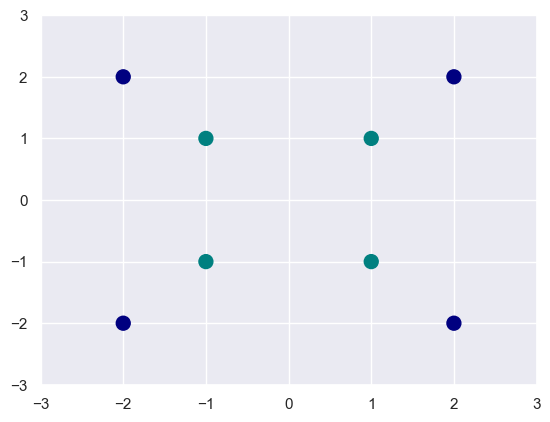

[[ 2.  2. -2. -2.  1.  1. -1. -1.]
 [ 2. -2. -2.  2.  1. -1. -1.  1.]]


In [24]:
xp = np.array([2., 2., -2., -2.])
yp = np.array([2., -2., -2., 2.])
xn = np.array([1., 1., -1., -1.])
yn = np.array([1., -1., -1., 1.])
a= np.array([xp ,yp])
b= np.array([xn,yn])
X = np.concatenate((a, b), axis=1)
y = [1, 1, 1, 1, -1, -1, -1, -1]
plt.scatter(X[0,:], X[1,:], c=y, s=100, cmap=mycmap)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()
print(X)

Nosso objetivo de descobrir um hiperplano separador que discrimine com precis√£o as duas classes se tornou mais √°rduo. Obviamente, esse hiperplano n√£o existe no espa√ßo das vari√°veis de entrada ùí≥. Portanto, devemos usar um SVM n√£o linear. Em outras palavras, usar uma fun√ß√£o $\phi$ que mapeia o espa√ßo n√£o linear de entrada para algum espa√ßo ùíµ de caracter√≠sticas combinadas.

Sup√µe-se

$$
z=\phi \left( x_1,x_2 \right)= \left\{
\begin{array}{c}
\left(4-x_2+|x_1-x_2|, 4-x_1+|x_1-x_2|\right)  & \text{se  }\sqrt{x_1^2+x_2^2}>2\\
\left(x_1,x_2\right) & c.c.
\end{array}\right.
$$

Dessa forma, os vetores transformados $z_+$ e $z_-$ s√£o dados por, respectivamente,
$$
z_+ = \left\{ \left(
\begin{array}{c}
2\\ 2
\end{array} \right), \left(
\begin{array}{c}
10\\ 6
\end{array} \right), \left(
\begin{array}{c}
6\\ 6
\end{array} \right),\left(
\begin{array}{c}
6\\ 10
\end{array} \right)
\right\}
$$
e
$$
z_- = \left\{ \left(
\begin{array}{c}
1\\ 1
\end{array} \right), \left(
\begin{array}{c}
1\\ -1
\end{array} \right), \left(
\begin{array}{c}
-1\\ -1
\end{array} \right),\left(
\begin{array}{c}
-1\\ 1
\end{array} \right)
\right\}
$$

In [25]:
Z = np.zeros([2,8])
y = [1, 1, 1, 1, -1, -1, -1, -1]
for i in range(0,8):
  if np.sqrt(X[0][i]**2+X[1][i]**2)>2.:
    print(i,X[0][i],X[1][i],abs(X[0][i]-X[1][i]))
    Z[0][i] = 4. - X[1][i] + abs(X[0][i]-X[1][i])
    Z[1][i] = 4. - X[0][i] + abs(X[0][i]-X[1][i])
  else:
    Z[0][i] = X[0][i]
    Z[1][i] = X[1][i]
print(Z)

0 2.0 2.0 0.0
1 2.0 -2.0 4.0
2 -2.0 -2.0 0.0
3 -2.0 2.0 4.0
[[ 2. 10.  6.  6.  1.  1. -1. -1.]
 [ 2.  6.  6. 10.  1. -1. -1.  1.]]


Coeficientes do modelo w1, w2 =[[1. 1.]]
b = [-3.]


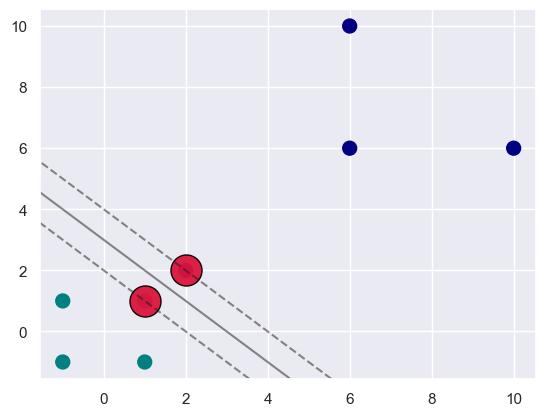

In [26]:
model = SVC(kernel='linear', C=1E10)
model.fit(Z.T, y)
plt.scatter(Z[0,:], Z[1,:], c=y, s=100, cmap=mycmap)
plot_SVC(model)

Uma vez que os dados de entrada foram mapeados para a dimens√£o ùíµ, o problema √© similar ao resolvido anteriormente,
$$
\tilde\omega^T z^{(j)}+\tilde{b} = \sum_{i=1}^{n_{sv}} \alpha_i y^{(i)} \langle z^{(i)},z^{(j)}\rangle + \tilde{b} = y^{(i)}
$$
onde $\langle z^{(i)},z^{(j)}\rangle$ √© o produto interno entre os vetores $z^{(i)}$ e $z^{(j)}$ e $n_{sv}$ √© o n√∫mero de vetores de suporte. O s√≠mbolo $\tilde{ }$ serve apenas para alertar que estamos no espa√ßo ùíµ.

Para nosso exemplo, teremos,
$$
\alpha_1 y^{(1)} z^{(1)}\cdot z^{(1)} + \alpha_2 y^{(2)} z^{(2)}\cdot z^{(1)} + \alpha_3 y^{(3)} z^{(3)}\cdot z^{(1)} + \tilde{b} = y^{(1)} \\
\alpha_1 y^{(1)} z^{(1)}\cdot z^{(2)} + \alpha_2 y^{(2)} z^{(2)}\cdot z^{(2)} + \alpha_3 y^{(3)} z^{(3)}\cdot z^{(2)} + \tilde{b} = y^{(2)} \\ \tag{1}
\alpha_1 y^{(1)} z^{(1)}\cdot z^{(3)} + \alpha_2 y^{(2)} z^{(2)}\cdot z^{(3)} + \alpha_3 y^{(3)} z^{(3)}\cdot z^{(3)} + \tilde{b} = y^{(3)}
$$

Por inspe√ß√£o, verifica-se que os vetores de suporte s√£o 2: $(1,1)$ para $y=-1$ e $(2,2)$, para $y=+1$. Dessa forma, pode-se escrever os vetores de suporte $sv_i, i=1,2$ como,
$$
sv_1 = \left(
\begin{array}{c}
 1 \\1
\end{array} \right)
 \qquad
sv_2 = \left(
\begin{array}{c}
2\\ 2
\end{array} \right)
$$

Substituindo-se os valores nas equa√ß√µes $(1)$, e adicionando a restri√ß√£o de que $\sum_iy^{(i)}\alpha_i=0$ tem-se:
 $$ \begin{array}{r c}
  - \alpha_1 z^{(1)}\cdot z^{(1)} + \alpha_2 z^{(2)}\cdot z^{(1)} + \tilde{b} &= -1 \\
-\alpha_1 z^{(1)}\cdot z^{(2)} + \alpha_2 z^{(2)}\cdot z^{(2)} + \tilde{b} &= +1 \\
 -\alpha_1  + \alpha_2  &= 0
 \end{array}
$$

Dado que $\langle z^{(1)},z^{(1)}\rangle=2$, $\langle z^{(2)},z^{(2)}\rangle=8$ e $\langle z^{(1)},z^{(2)}\rangle=4$, o problema resume-se a:
 $$
-2\alpha_1 + 4\alpha_2 + \tilde{b} = -1 \\
-4\alpha_1 + 8\alpha_2 + \tilde{b} = +1 \\ \tag{2}
-\alpha_1  + \alpha_2  + 0\tilde{b} = 0
$$

Encontre os valores de $\alpha$ e depois de $\tilde{b}$ e $\tilde{\omega}$. Lembre-se que:
$$
\tilde\omega = \sum_{i=1}^{n_{sv}} \alpha_i y^{(i)} z^{(i)}
$$

In [27]:
# Sua resposta

In [28]:
#@title Gabarito
sv = np.array([[ 1., 1.],[ 2., 2.]])
y_sv = np.array([-1, 1, 0])
A = np.zeros([3,3])
for i in range(0,2):
  for j in range(0,2):
    A[i][j] = y_sv[j]*np.dot(sv[i,:],sv[j,:])
  A[i][2]=1
A[2,:] = [-1, 1, 0]
print(A)
print(Z)
alphas = np.linalg.solve(A,y_sv)
print('alpha 1 = {:4.2f}, alpha 2 = {:4.2f}'.format(alphas[0], alphas[1]))
print('b = {:4.2f}'.format(alphas[2]))
w=np.zeros([1,2])
for i in range (0,2):
  w += alphas[i]*y_sv[i]*sv[i,:]
w=np.array(w)
print('w 1 = {:4.2f}, w 2 = {:4.2f}'.format(w[0][0], w[0][1]))

[[-2.  4.  1.]
 [-4.  8.  1.]
 [-1.  1.  0.]]
[[ 2. 10.  6.  6.  1.  1. -1. -1.]
 [ 2.  6.  6. 10.  1. -1. -1.  1.]]
alpha 1 = 1.00, alpha 2 = 1.00
b = -3.00
w 1 = 1.00, w 2 = 1.00


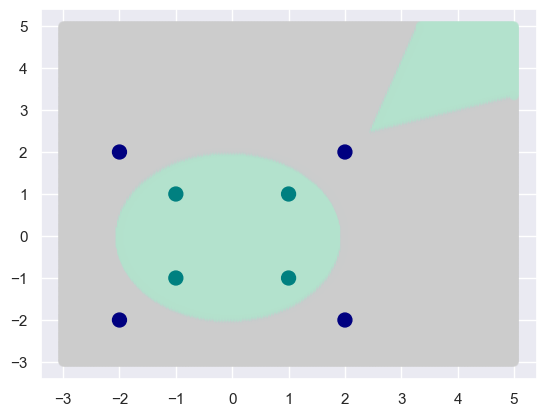

In [29]:
xlim = [-3., 5.]
ylim = [-3., 5.]
# Grid para avalia√ß√£o do modelo
h = np.linspace(xlim[0], xlim[1], 300)
v = np.linspace(ylim[0], ylim[1], 300)
V,H = np.meshgrid(v, h)
xy = np.vstack([H.ravel(), V.ravel()])
dim = xy.shape[1]
P=np.zeros([dim])

z_t=np.zeros([2])
for i in range(xy.shape[1]):
  if np.sqrt(xy[0][i]**2+xy[1][i]**2)>2.:
    z_t[0] = 4. - xy[1][i] + abs(xy[0][i]-xy[1][i])
    z_t[1] = 4. - xy[0][i] + abs(xy[0][i]-xy[1][i])
  else:
    z_t[0] = xy[0][i]
    z_t[1] = xy[1][i]
  P[i] = np.sign(w[0][0]*z_t[0]+w[0][1]*z_t[1]+alphas[2])
plt.scatter(xy[0,:],xy[1,:],c=P,alpha=0.5,cmap = 'Pastel2')
plt.scatter(X[0,:], X[1,:], c=y, s=100, cmap=mycmap)

Olhando para as respostas no espa√ßo de entrada, podemos ficar tentados a pensar que essa n√£o √© uma classifica√ß√£o razo√°vel; no entanto, √© o que diz o nosso modelo, e nosso modelo √© consistente com todos os dados de treinamento.

Como sempre, n√£o h√° garantias sobre a precis√£o da generaliza√ß√£o e, se n√£o estamos felizes com nossa generaliza√ß√£o, o culpado mais prov√°vel √© nossa escolha de mapeamento.


### O truque do kernel

Nossa defini√ß√£o de $\phi$ do exemplo anterior preservou o n√∫mero de dimens√µes. Em outras palavras, nossos espa√ßos de entrada ùí≥ e de mapeamento ùíµ s√£o do mesmo tamanho.

No entanto, geralmente √© o caso de que, para separar efetivamente os dados, precisamos usar um espa√ßo de com dimens√£o (√†s vezes muito) maior que o nosso espa√ßo de entrada.

O *truque* √© que, dados dois vetores $x^{(i)}$ e $x^{(j)}$ no espa√ßo ùí≥, pode-se provar que n√£o h√° necessidade de descriminar cada vetor $z^{(i)}$ e $z^{(j)}$ da transforma√ß√£o $x^{(i)} \rightarrow z^{(i)}$ e $x^{(j)} \rightarrow z^{(j)}$. I.√©, a dimensionalidade de ùíµ n√£o aparece explicitamente na express√£o, mas temos que realizar o produto interno $z^{(i)} \cdot z^{(j)}$ no espa√ßo ùíµ. Em outras palavras, precisamos de um n√∫mero, um valor. Com esse valor, o produto interno, elabora-se todo problema de vetores de suporte no espa√ßo ùíµ, que nunca foi visitado ou conhecido e retorna-se com vetores de suporte que vivem em seu espa√ßo ùíµ, calcula-se o desempenho baseado no n√∫mero de vetores de suporte. Pode-se dizer que foi usado um espa√ßo realmente muito sofisticado!!!!

Se algu√©m perguntar que espa√ßo √© esse, diga que a exist√™ncia dele √© suficiente!

 ![](https://drive.google.com/uc?export=view&id=1DBXMAZDTDgel8KdFqWs7ZqDLh15Iriw9)

Importante ressaltar que, nesse caso, os vetores de suporte est√£o no espa√ßo ùíµ. Porque estamos trabalhando no espa√ßo ùíµ, o hiperplano est√° l√°, a margem est√° l√°, e a margem ir√° tocar alguns pontos, os vetores de suporte. E voc√™ pode identific√°-los, no espa√ßo ùíµ.

Outro ponto importante √© que existem regras para exist√™ncia de kernels, i√©, voc√™ n√£o pode inventar um valor de sua cabe√ßa. Existe uma transforma√ß√£o $\phi(x)=z$, ùúô:ùí≥‚Üíùíµ, que √© aplicada aos vetores $x$ e $x'$ transformando-os, respectivamente, em $z$ e $z'$ e o kernel √© exatamente o produto interno desses vetores $z$ e $z'$.

Linear | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Express√£o: $K(x^{(i)},x^{(j)})$ &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; | Par√¢metros
--- | :----------------: | :---:
Linear | $x^{(i)}\cdot x^{(j)}$ |
Polinomial | $\left(x^{(i)}\cdot x^{(j)}+1\right)^d$ | $d$
RBF |$\exp\left(-\gamma||x^{(i)}- x^{(j)}||^2\right)$ | $\gamma>0$
Hiperb√≥lico | $\tanh\left(k(^{(i)}\cdot x^{(j)}+c\right)$ | $k,c$

RBF (do ingl√™s, Radial Basis Funtion) √© o kernel mais usado nas classifica√ß√µes SVM.





### Exemplo Kernel

Considere os mesmos dados do exemplo anterior.


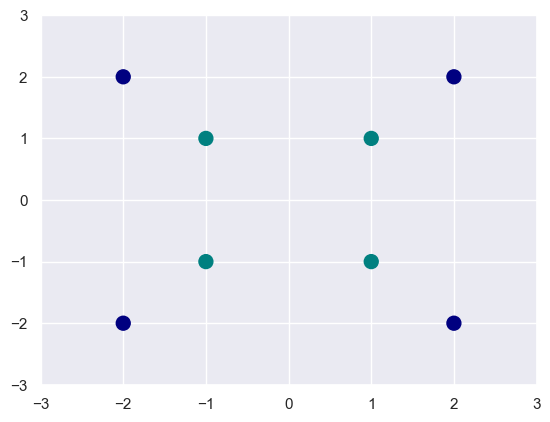

[[ 2.  2. -2. -2.  1.  1. -1. -1.]
 [ 2. -2. -2.  2.  1. -1. -1.  1.]]


In [30]:
xp = np.array([2., 2., -2., -2.])
yp = np.array([2., -2., -2., 2.])
xn = np.array([1., 1., -1., -1.])
yn = np.array([1., -1., -1., 1.])
a= np.array([xp ,yp])
b= np.array([xn,yn])
X = np.concatenate((a, b), axis=1)
y = [1, 1, 1, 1, -1, -1, -1, -1]
plt.scatter(X[0,:], X[1,:], c=y, s=100, cmap=mycmap)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()
print(X)

Vamos agora considerar uma fun√ß√£o de mapeamento alternativa. Sup√µe-se

$$
z=\phi_2 \left( x_1,x_2 \right)= \left(
\begin{array}{c}
x_1\\
x_2 \\
\frac{\left(x_1^2+x_2^2\right)-5}{3}
\end{array}\right)
$$
que transforma nossos dados do espa√ßo de entrada bidimensional para um espa√ßo tridimensional. Usando esse mapeamento alternativo, os novos vetores transformados $z_+$ e $z_-$ s√£o dados por, respectivamente,
$$
z_+ = \left\{ \left(
\begin{array}{c}
2\\ 2 \\1
\end{array} \right), \left(
\begin{array}{c}
2\\-2\\1
\end{array} \right), \left(
\begin{array}{c}
-2\\-2\\1
\end{array} \right),\left(
\begin{array}{c}
-2\\2\\1
\end{array} \right)
\right\}
$$
e
$$
z_- = \left\{ \left(
\begin{array}{c}
1\\ 1 \\-1
\end{array} \right), \left(
\begin{array}{c}
1\\ -1 \\-1
\end{array} \right), \left(
\begin{array}{c}
-1\\ -1 \\-1
\end{array} \right),\left(
\begin{array}{c}
-1\\ 1 \\-1
\end{array} \right)
\right\}
$$

In [31]:
Z = np.zeros([3,8])
y = [1, 1, 1, 1, -1, -1, -1, -1]
for i in range(0,8):
  Z[0][i] = X[0][i]
  Z[1][i] = X[1][i]
  Z[2][i] = ((X[0][i]**2+X[1][i]**2)-5)/3
print(Z)

[[ 2.  2. -2. -2.  1.  1. -1. -1.]
 [ 2. -2. -2.  2.  1. -1. -1.  1.]
 [ 1.  1.  1.  1. -1. -1. -1. -1.]]


In [32]:
model = SVC(kernel='linear', C=1E10)
model.fit(Z.T, y)
print('Coeficientes do modelo w1, w2, w3 ='+ str(model.coef_))
print('b = '+str(model.intercept_))

Coeficientes do modelo w1, w2, w3 =[[7.93569817e-05 7.93569817e-05 9.99761929e-01]]
b = [3.4010135e-05]


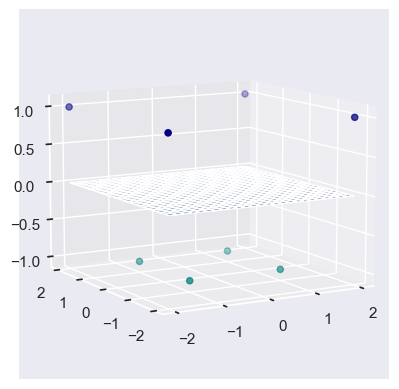

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[0,:], Z[1,:],Z[2,:], c=y, cmap=mycmap)
x3 = lambda x1,x2: (-model.intercept_[0]-model.coef_[0][0]*x1-model.coef_[0][1]*x2) / model.coef_[0][2]

tmp = np.linspace(-2,2,51)
x1,x2 = np.meshgrid(tmp,tmp)

ax.plot_surface(x1, x2, x3(x1,x2))
ax.view_init(10, -120)

Nesse caso, os 8 n√≥s s√£o vetores de suporte em ùíµ. Para verificar isso, plote a figura 3D acima __com as margens__, modificando a linha:
```
x3 = lambda x1,x2: (-model.intercept_[0]-model.coef_[0][0]*x1-model.coef_[0][1]*x2) / model.coef_[0][2]

```

Perceba que a equa√ß√£o acima foi obtida de
\begin{equation}
\boldsymbol{\omega}^T\boldsymbol{z}+b = 0
\end{equation}
que √© verdadeira no hiperplano de separa√ß√£o. Nas margens,
\begin{equation}
\boldsymbol{\omega}^T\boldsymbol{z}+b = \pm 1
\end{equation}


Calcule os valores de $\alpha$ e $\tilde{b}$.

In [34]:
#Sua resposta


In [35]:
#@title Gabarito
sv = np.array(Z.T)
y_sv = [1, 1, 1, 1, -1, -1, -1, -1, 0]
A = np.zeros([9,9])
for i in range(0,8):
  for j in range(0,8):
    A[i][j] = y_sv[j]*np.dot(sv[i,:],sv[j,:])
  A[i][8]=1
A[8,:] = [1, 1, 1, 1, -1, -1, -1, -1, 0]
alphas = np.linalg.solve(A,y_sv)
print('alpha 1 = {:4.2f}, alpha 2 = {:4.2f}, alpha 3 = {:4.2f}, alpha 4 = {:4.2f}'.format(alphas[0], alphas[1], alphas[2], alphas[3]))
print('alpha 5 = {:4.2f}, alpha 6 = {:4.2f}, alpha 7 = {:4.2f}, alpha 8 = {:4.2f}'.format(alphas[4], alphas[5], alphas[6], alphas[7]))
print('b = {:4.2f}'.format(alphas[8]))
w=np.zeros([1,3])
for i in range (0,7):
  w += alphas[i]*y_sv[i]*sv[i,:]
w=np.array(w)
print('w 1 = {:4.2f}, w 2 = {:4.2f}, w 3 = {:4.2f}'.format(w[0][0], w[0][1], w[0][2]))
print(w)

alpha 1 = 0.51, alpha 2 = -0.21, alpha 3 = -0.16, alpha 4 = 0.36
alpha 5 = 1.62, alpha 6 = -1.27, alpha 7 = 0.28, alpha 8 = -0.12
b = -0.00
w 1 = 0.13, w 2 = -0.13, w 3 = 1.12
[[ 0.125 -0.125  1.125]]


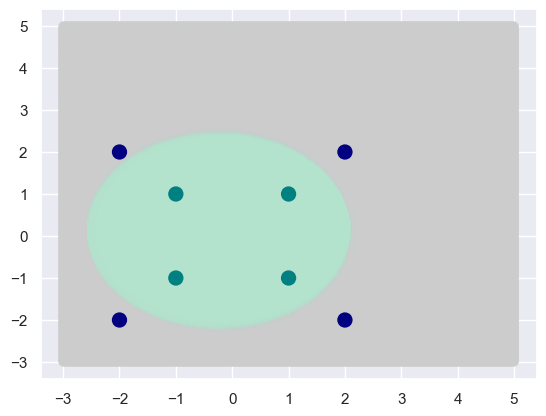

In [36]:
xlim = [-3., 5.]
ylim = [-3., 5.]
# create grid to evaluate model
h = np.linspace(xlim[0], xlim[1], 300)
v = np.linspace(ylim[0], ylim[1], 300)
V,H = np.meshgrid(v, h)
xy = np.vstack([H.ravel(), V.ravel()])
dim = xy.shape[1]
P=np.zeros([dim])
z_t=np.zeros([3])
for i in range(xy.shape[1]):
  z_t[0] = xy[0][i]
  z_t[1] = xy[1][i]
  z_t[2] = ((xy[0][i]**2+xy[1][i]**2)-5)/3
  P[i] = np.sign(w[0][0]*z_t[0]+w[0][1]*z_t[1]+w[0][2]*z_t[2]+alphas[2])
plt.scatter(xy[0,:],xy[1,:],c=P,alpha=0.5,cmap = 'Pastel2')
plt.scatter(X[0,:], X[1,:], c=y, s=100, cmap=mycmap)

Melhorou, n√£o??

### Modelando (SVM com Scikit-learn)

O algoritmo SVM oferece uma op√ß√£o de fun√ß√µes do kernel para executar seu processamento. Basicamente, o mapeamento de dados em um espa√ßo dimensional superior √© chamado de kernelling. A fun√ß√£o matem√°tica usada para a transforma√ß√£o √© conhecida como a fun√ß√£o do kernel e pode ser de diferentes tipos, como:

¬†¬†¬†¬† 1. Linear
¬†¬†¬†¬† 2. Polinomial
¬†¬†¬†¬† 3. Radial Basis Function (RBF)
¬†¬†¬†¬† 4. Sigmoide
Cada uma dessas fun√ß√µes tem suas caracter√≠sticas, seus pr√≥s e contras e sua equa√ß√£o, mas como n√£o h√° maneira f√°cil de saber qual fun√ß√£o tem melhor desempenho com qualquer dado, geralmente escolhemos diferentes fun√ß√µes e comparamos os resultados.

O exemplo a seguir usa o padr√£o, RBF (Radial Basis Function), e serviu para ilustrar a aula.

Todo conte√∫do desta parte ser√° assunto da pr√≥xima aula de exerc√≠cios, n√£o se preocupe com ele no momento.

In [37]:
def plot_SVC(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x = np.linspace(xlim[0], xlim[1], 300)
    y = np.linspace(ylim[0], ylim[1], 300)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    ax.contour(X, Y, P, colors='crimson',
               levels=[0], alpha=0.5,
               linestyles=['--'])

    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=50, linewidth=1, facecolors='crimson');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

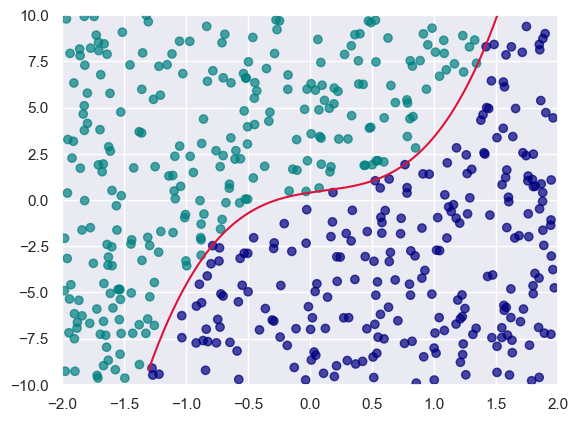

In [38]:
np.random.seed(42)
x = np.random.uniform(-2, 2, size=500)
y = np.random.uniform(-10, 10, size=500)
x_lim = np.arange(-1.3, 1.8, 0.01)
y_lim = 3.*x_lim**3+1.*x_lim-1.*x_lim**2+0.4
X=[]
Y=[]
for i,j in zip(x,y):
  y_t = 3.*i**3+1.*i-1.*i**2+0.4
  X.append([i,j])
  if y_t>j:
    Y.append(1)
  else:
    Y.append(-1)
X=np.array(X)
Y=np.array(Y)
plt.plot(x_lim,y_lim, color = 'crimson')
plt.ylim(-10, 10)
plt.xlim(-2,2)
plt.scatter(X[:,0],X[:,1],c=Y,alpha=0.7,cmap = mycmap)

In [39]:
# Create a SVC classifier using an RBF kernel
#clf = SVC(kernel='rbf', random_state=0, tol=0.001, gamma='auto', C=1000)
clf = SVC(kernel='rbf', random_state=0, tol=0.001, gamma=0.1, C=1e5)
# Train the classifier
clf.fit(X, Y)

SVC(C=100000.0, gamma=0.1, random_state=0)

N√∫mero de vetores de suporte:  16
Graus de liberdade:  500
Limite erro:  0.032


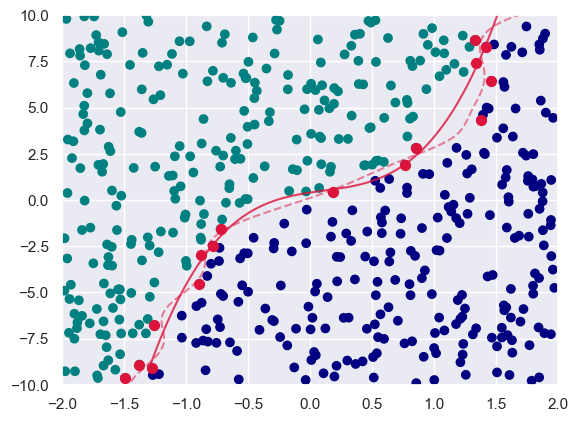

In [40]:
# Plote os dados
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap = mycmap)
# Plote o contorno de decis√£o e os vetores de suporte em vermelho
plot_SVC(clf)

plt.plot(x_lim,y_lim,alpha = 0.8, color = 'crimson')
plt.ylim(-10, 10)
plt.xlim(-2,2)
print('N√∫mero de vetores de suporte: ', clf.support_.size)
print('Graus de liberdade: ', len(X))
print('Limite erro: ', clf.support_.size/len(X))

#### Par√¢metros de ajuste

Escolher o kernel correto √© crucial. O desempenho do modelo depende de uma *s√°bia* escolha da fun√ß√£o de kernel. A d√∫vida sobre como decidir qual defini√ß√£o de kernel funcionar√° de forma eficiente para o seu conjunto de dados n√£o √© s√≥ sua.

A escolha de um kernel depende totalmente do tipo de conjunto de dados em que voc√™ est√° trabalhando. Se for linearmente separ√°vel, voc√™ deve optar pela fun√ß√£o linear do kernel, pois √© muito f√°cil de usar e a complexidade √© muito menor em compara√ß√£o com outras. Portanto, comece com uma hip√≥tese de que seus dados sejam linearmente separ√°veis ‚Äã‚Äãe escolha uma fun√ß√£o de kernel linear.

Voc√™ pode ent√£o trabalhar em dire√ß√£o √†s fun√ß√µes mais complexas do kernel. Normalmente, usamos SVM com RBF ou linear, porque outros kernels, como kernel polinomial, t√™m baixa efici√™ncia e raramente s√£o a melhor op√ß√£o.

Para ajudar na escolha, existe uma biblioteca do `sklearn`



```
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = [
	{"kernel":
		["linear"],
		"C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000]},
	{"kernel":
		["poly"],
		"degree": [2, 3, 4],
		"C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000]},
	{"kernel":
		["rbf"],
		"gamma": ["auto", "scale"],
		"C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000]}
]

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train, y_train)


# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)
```

Uma pesquisa usando  `GridSearchCV` testar√° exaustivamente todas as combina√ß√µes poss√≠veis desses hiperpar√¢metros, treinando um SVM para cada conjunto. A pesquisa em grade reportar√° ent√£o os melhores hiperpar√¢metros (ou seja, aqueles que maximizaram a precis√£o). Voc√™ pode inspecionar os melhores par√¢metros encontrados pelo GridSearchCV no atributo `best_params_` e o melhor estimador no atributo `best_estimator_`

Uma vez que tenha a melhor combina√ß√£o de hiperpar√¢metros, o `fit` constr√≥i um √∫nico novo modelo.


Mas, isso √© assunto da pr√≥xima aula...

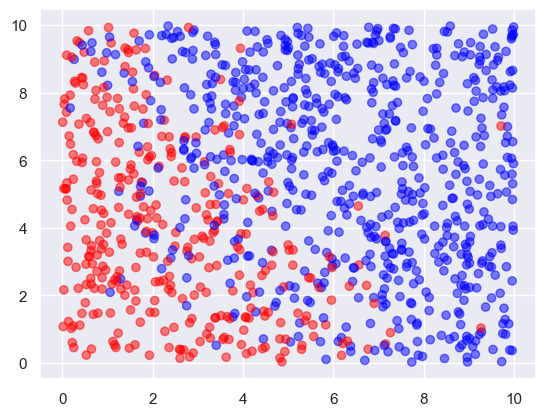

In [48]:
x = np.random.uniform(0, 10, size=1000)
y = np.random.uniform(0, 10, size=1000)
linear = x+0.5*y-6
p = 1/(1+np.exp(-linear))
z = np.random.binomial(n=1, p=p)
colors = ['red' if value == 0 else 'blue' for value in z]
plt.scatter(x,y,c=colors, alpha=0.5)

In [49]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = [
	{"kernel":
		["linear"],
		"C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000]},
	{"kernel":
		["poly"],
		"degree": [2, 3, 4],
		"C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000]},
	{"kernel":
		["rbf"],
		"gamma": ["auto", "scale"],
		"C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000]}
]

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(np.column_stack((x,y)), z)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END ...........C=0.0001, kernel=linear;, score=0.665 total time=   0.0s
[CV 2/5] END ...........C=0.0001, kernel=linear;, score=0.660 total time=   0.0s
[CV 3/5] END ...........C=0.0001, kernel=linear;, score=0.660 total time=   0.0s
[CV 4/5] END ...........C=0.0001, kernel=linear;, score=0.660 total time=   0.0s
[CV 5/5] END ...........C=0.0001, kernel=linear;, score=0.660 total time=   0.0s
[CV 1/5] END ............C=0.001, kernel=linear;, score=0.870 total time=   0.0s
[CV 2/5] END ............C=0.001, kernel=linear;, score=0.890 total time=   0.0s
[CV 3/5] END ............C=0.001, kernel=linear;, score=0.895 total time=   0.0s
[CV 4/5] END ............C=0.001, kernel=linear;, score=0.830 total time=   0.0s
[CV 5/5] END ............C=0.001, kernel=linear;, score=0.865 total time=   0.0s
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.885 total time=   0.0s
[CV 2/5] END ..............C=0.1, kernel=linear

c:\Users\mathe\.virtualenvs\POLI-7HcGD_UH\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
